In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
!unzip '/content/drive/My Drive/DATASETS/intel-image-classification.zip' -d 'intel-image-classification/'


Archive:  /content/drive/My Drive/DATASETS/intel-image-classification.zip
  inflating: intel-image-classification/seg_train.zip  
  inflating: intel-image-classification/seg_test.zip  
  inflating: intel-image-classification/seg_pred.zip  


In [0]:
!unzip 'intel-image-classification/seg_train.zip' -d 'intel-image-classification/seg_train/'
!unzip 'intel-image-classification/seg_test.zip' -d 'intel-image-classification/seg_test/'
!unzip 'intel-image-classification/seg_pred.zip' -d 'intel-image-classification/seg_pred/'

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Input, ZeroPadding2D, Conv2D, MaxPooling2D, Activation, add
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow.keras
from tensorflow.keras.layers import Conv2D, Dropout, MaxPool2D, AvgPool2D, Add, Dense 
from tensorflow.keras.preprocessing.image import load_img, img_to_array


from keras.models import Model

from keras.utils import plot_model

import warnings
#warnings.warn("ignore")
import os

Using TensorFlow backend.


In [0]:
#!unzip 'intel-image-classification.zip'

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_width, image_height = 150,150

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest'
)

test_datagen = ImageDataGenerator( rescale = 1./255. )

train_generator = train_datagen.flow_from_directory(
                    "intel-image-classification/seg_train/seg_train/",
                    batch_size=128,
                    class_mode='categorical',
                    target_size=(image_width, image_height)
)     

test_generator =  test_datagen.flow_from_directory(
                    "intel-image-classification/seg_test/seg_test/",
                    batch_size=128, 
                    class_mode='categorical',
                    target_size=(image_width, image_height)
)


Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [0]:
def inception_module(layer_in, f1, f2_in, f2_out, f3_in, f3_out, f4_out):
    # 1x1 conv
    conv1 = Conv2D(f1, (1,1), padding='same', activation='relu')(layer_in)
    # 3x3 conv
    conv3 = Conv2D(f2_in, (1,1), padding='same', activation='relu')(layer_in)
    conv3 = Conv2D(f2_out, (3,3), padding='same', activation='relu')(conv3)
    # 5x5 conv
    conv5 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(layer_in)
    conv5 = Conv2D(f3_out, (5,5), padding='same', activation='relu')(conv5)
    # 3x3 max pooling
    pool = MaxPooling2D((3,3), strides=(1,1), padding='same')(layer_in)
    pool = Conv2D(f4_out, (1,1), padding='same', activation='relu')(pool)
    # concatenate filters, assumes filters/channels last
    layer_out = concatenate([conv1, conv3, conv5, pool], axis=-1)
    return layer_out

In [0]:
def identity_block(X, f, filters, stage, block):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. We'll need this later to add back to the main path. 
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


In [0]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X
    

    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)

    
    ##### SHORTCUT PATH ####
    X_shortcut = Conv2D(F3, (1, 1), strides = (s,s), name = conv_name_base + '1', kernel_initializer = glorot_uniform(seed=0))(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

In [0]:
def DeepResNetInception(input_shape = (150, 150, 3), classes = 6):   
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

   
    # Zero-Padding
    #X = ZeroPadding2D((3, 3))(X_input)
    X = X_input
    
    # Stage 1
    X = Conv2D(16, (3, 3), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)

    # Stage 2
    X = Conv2D(32, (3, 3), strides = (2, 2), name = 'conv2', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)

    
    # Stage 3
    X = Conv2D(64, (3, 3), strides = (2, 2), name = 'conv3', kernel_initializer = glorot_uniform(seed=0))(X)
    X = Activation('relu')(X)
       

    # inception module (out 128)
    X = inception_module(X, f1=32, f2_in=(32+8), f2_out=64, f3_in=8, f3_out=16, f4_out=16)
    X = Activation('relu')(X)    

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [128, 128, 256], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 256], stage=4, block='b')
    X = Activation('relu')(X)    
    
    # inception module (out 256)
    X = inception_module(X, f1=64, f2_in=(64+16), f2_out=128, f3_in=16, f3_out=32, f4_out=32)
    X = Activation('relu')(X)    

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [256, 128, 512], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 512], stage=5, block='b')
    X = Activation('relu')(X)
    
    # inception module (out 512)
    X = inception_module(X, f1=128, f2_in=(128+32), f2_out=256, f3_in=32, f3_out=64, f4_out=64)
    X = Activation('relu')(X)    

    # Stage 5
    X = convolutional_block(X, f = 3, filters = [512, 512, 1024], stage = 6, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 1024], stage=6, block='b')
    X = Activation('relu')(X)    



    # AVGPOOL
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    # output layer
    X = Flatten()(X)
    #X = Dropout(0.25)(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes),  kernel_initializer = glorot_uniform(seed=0))(X)
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='DeepRes-ception')

    return model

In [0]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import cv2
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import keras.backend as K
import tensorflow as tf

from keras.layers.merge import concatenate

In [0]:
img_shape = (150, 150, 3)
model = DeepResNetInception(input_shape=img_shape, classes=6)

In [0]:
model.summary()


Model: "DeepRes-ception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 74, 74, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 74, 74, 16)   0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 36, 36, 32)   4640        activation_1[0][0]               
____________________________________________________________________________________

In [0]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [0]:
# fits the model on batches with real-time data augmentation:
trained_model = model.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=50
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/50





110/110 [==============================] - 106s 966ms/step - loss: 1.4569 - acc: 0.3930 - val_loss: 1.1580 - val_acc: 0.5283
Epoch 2/50
110/110 [==============================] - 93s 841ms/step - loss: 1.1152 - acc: 0.5467 - val_loss: 0.9678 - val_acc: 0.6063
Epoch 3/50
110/110 [==============================] - 94s 854ms/step - loss: 1.0358 - acc: 0.5891 - val_loss: 0.8959 - val_acc: 0.6387
Epoch 4/50
110/110 [==============================] - 94s 858ms/step - loss: 0.9697 - acc: 0.6148 - val_loss: 0.9005 - val_acc: 0.6430
Epoch 5/50
110/110 [==============================] - 94s 856ms/step - loss: 0.9114 - acc: 0.6473 - val_loss: 0.8856 - val_acc: 0.6523
Epoch 6/50
110/110 [==============================] - 94s 855ms/step - loss: 0.8739 - acc: 0.6631 - val_loss: 0.7698 - val_acc: 0.7103
Epoch 7/50
110/110 [==============================] - 94s 856ms/step - loss: 0.8292 - a

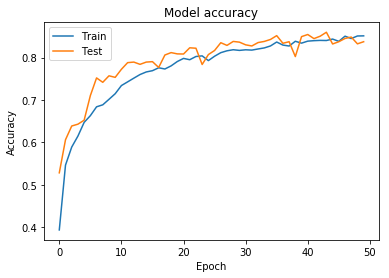

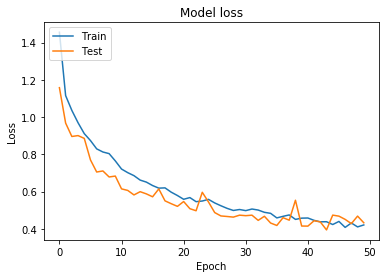

In [0]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.evaluate_generator(test_generator)

[0.43222342785199486, 0.837333333492279]

In [0]:
model.save_weights('Deep-Res-ception_with_no_BN_weights.h5')

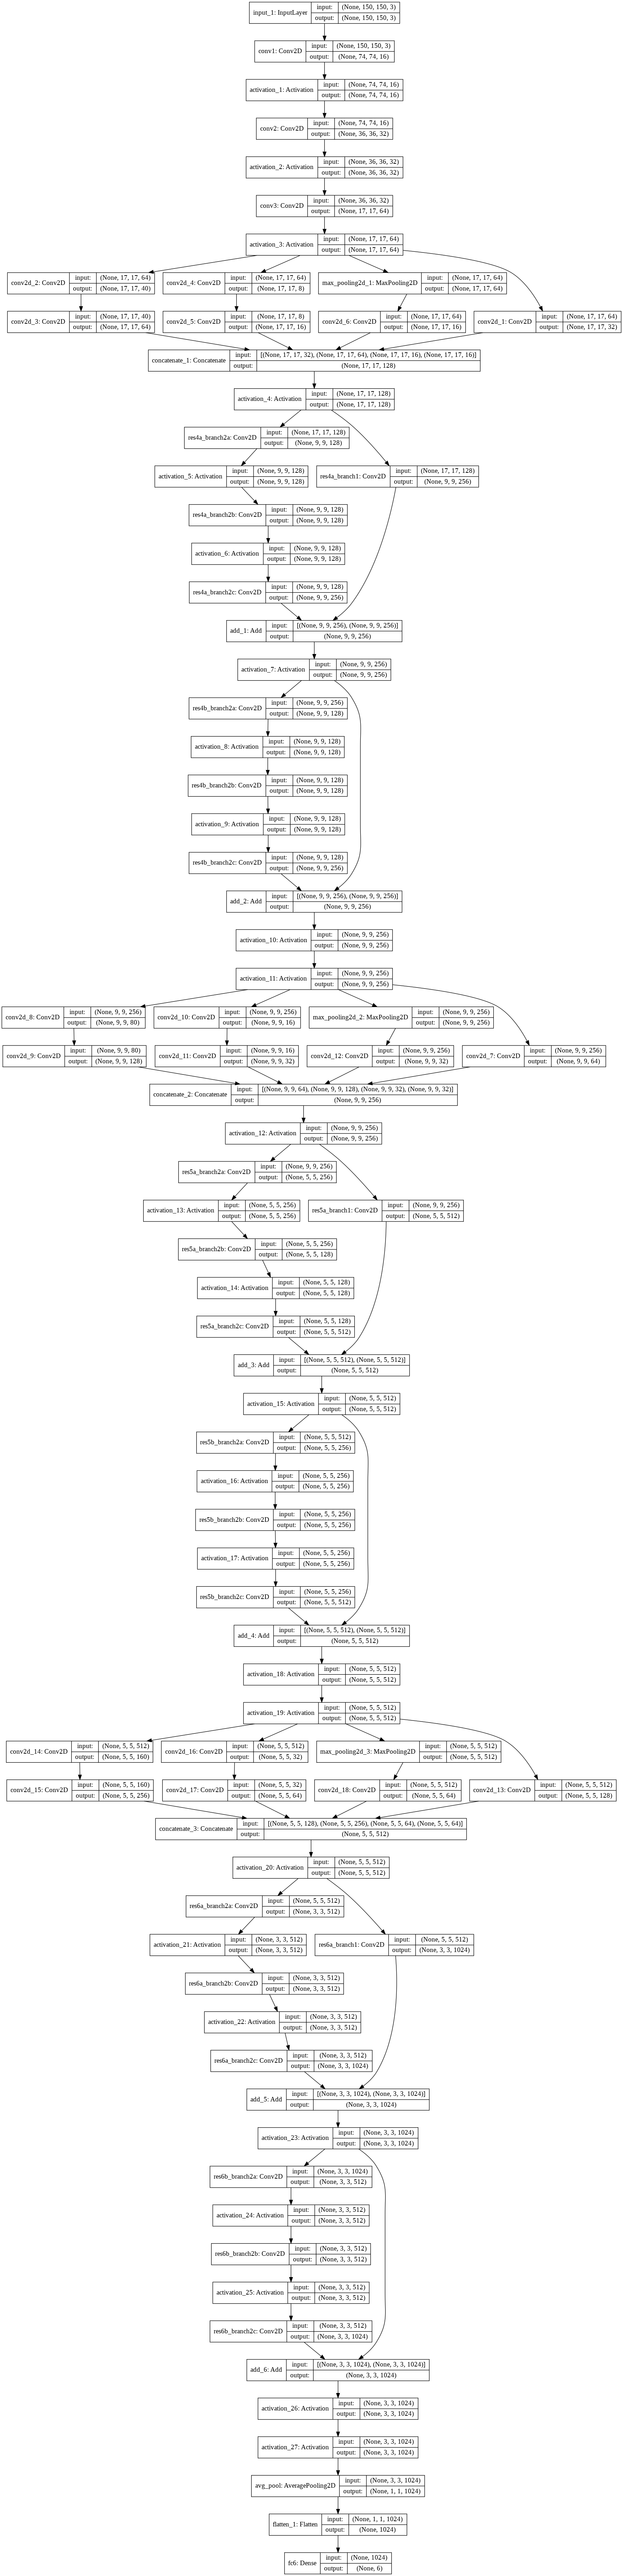

In [0]:
plot_model(model, show_shapes=True, to_file='Deep-Res-ception_with_no_BN_weights.png')

In [0]:
trained_model2 = model.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=50
)

Epoch 1/50
110/110 [==============================] - 93s 846ms/step - loss: 0.4032 - acc: 0.8528 - val_loss: 0.4275 - val_acc: 0.8467
Epoch 2/50
110/110 [==============================] - 92s 838ms/step - loss: 0.4042 - acc: 0.8523 - val_loss: 0.4000 - val_acc: 0.8587
Epoch 3/50
110/110 [==============================] - 92s 837ms/step - loss: 0.4164 - acc: 0.8497 - val_loss: 0.4244 - val_acc: 0.8447
Epoch 4/50
110/110 [==============================] - 92s 839ms/step - loss: 0.4017 - acc: 0.8521 - val_loss: 0.4292 - val_acc: 0.8480
Epoch 5/50
110/110 [==============================] - 93s 844ms/step - loss: 0.3845 - acc: 0.8578 - val_loss: 0.4031 - val_acc: 0.8503
Epoch 6/50
110/110 [==============================] - 93s 848ms/step - loss: 0.3780 - acc: 0.8614 - val_loss: 0.4733 - val_acc: 0.8230
Epoch 7/50
110/110 [==============================] - 93s 842ms/step - loss: 0.3887 - acc: 0.8571 - val_loss: 0.4433 - val_acc: 0.8450
Epoch 8/50
110/110 [==============================] - 9

In [0]:
model.save_weights('Deep-Res-ception_with_no_BN_weights_100epochs.h5')

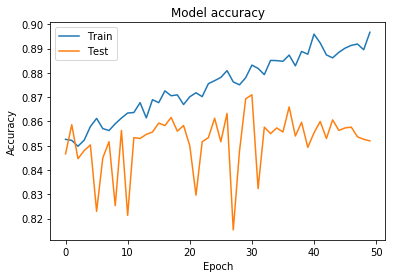

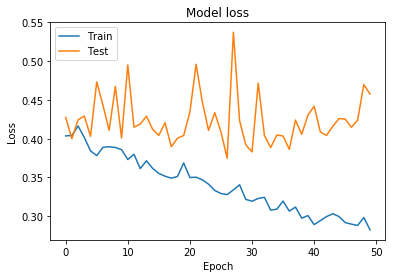

In [0]:
# Plot training & validation accuracy values
plt.plot(trained_model2.history['acc'])
plt.plot(trained_model2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model2.history['loss'])
plt.plot(trained_model2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
def appendHist(h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

In [0]:
all_hist = appendHist(trained_model.history, trained_model2.history)

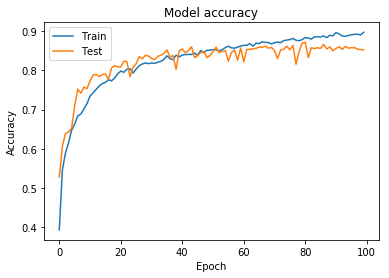

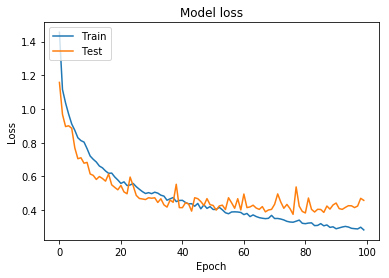

In [0]:
# Plot training & validation accuracy values
plt.plot(all_hist['acc'])
plt.plot(all_hist['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(all_hist['loss'])
plt.plot(all_hist['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
trained_model3 = model.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=25
)

Epoch 1/25
110/110 [==============================] - 95s 861ms/step - loss: 0.2860 - acc: 0.8942 - val_loss: 0.4409 - val_acc: 0.8547
Epoch 2/25
110/110 [==============================] - 93s 842ms/step - loss: 0.2933 - acc: 0.8896 - val_loss: 0.4139 - val_acc: 0.8623
Epoch 3/25
110/110 [==============================] - 94s 857ms/step - loss: 0.2995 - acc: 0.8896 - val_loss: 0.4284 - val_acc: 0.8573
Epoch 4/25
110/110 [==============================] - 94s 858ms/step - loss: 0.2824 - acc: 0.8963 - val_loss: 0.4096 - val_acc: 0.8610
Epoch 5/25
110/110 [==============================] - 94s 850ms/step - loss: 0.2961 - acc: 0.8896 - val_loss: 0.4367 - val_acc: 0.8503
Epoch 6/25
110/110 [==============================] - 92s 840ms/step - loss: 0.2696 - acc: 0.9002 - val_loss: 0.4285 - val_acc: 0.8617
Epoch 7/25
110/110 [==============================] - 91s 830ms/step - loss: 0.2783 - acc: 0.8982 - val_loss: 0.4209 - val_acc: 0.8657
Epoch 8/25
110/110 [==============================] - 9

In [0]:
model.save_weights('Deep-Res-ception_with_no_BN_weights_125epochs.h5')

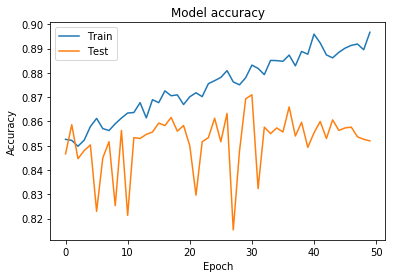

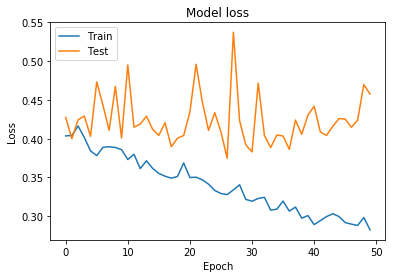

In [0]:
# Plot training & validation accuracy values
plt.plot(trained_model2.history['acc'])
plt.plot(trained_model2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model2.history['loss'])
plt.plot(trained_model2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
all_hist = appendHist(all_hist, trained_model3.history)

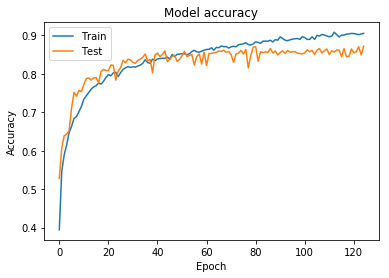

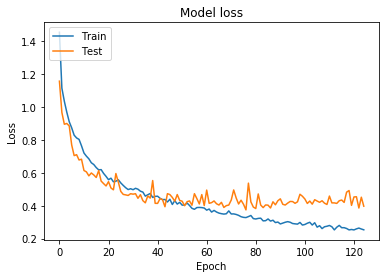

In [0]:
# Plot training & validation accuracy values
plt.plot(all_hist['acc'])
plt.plot(all_hist['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(all_hist['loss'])
plt.plot(all_hist['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
trained_model4 = model.fit_generator(
            train_generator,
            validation_data=test_generator,
            epochs=25
)

Epoch 1/25
110/110 [==============================] - 91s 828ms/step - loss: 0.2421 - acc: 0.9115 - val_loss: 0.5122 - val_acc: 0.8413
Epoch 2/25
110/110 [==============================] - 88s 803ms/step - loss: 0.2602 - acc: 0.9048 - val_loss: 0.4535 - val_acc: 0.8580
Epoch 3/25
110/110 [==============================] - 88s 802ms/step - loss: 0.2514 - acc: 0.9062 - val_loss: 0.4137 - val_acc: 0.8690
Epoch 4/25
110/110 [==============================] - 88s 803ms/step - loss: 0.2456 - acc: 0.9115 - val_loss: 0.4280 - val_acc: 0.8680
Epoch 5/25
110/110 [==============================] - 88s 804ms/step - loss: 0.2339 - acc: 0.9127 - val_loss: 0.4884 - val_acc: 0.8413
Epoch 6/25
110/110 [==============================] - 88s 799ms/step - loss: 0.2470 - acc: 0.9071 - val_loss: 0.4029 - val_acc: 0.8707
Epoch 7/25
110/110 [==============================] - 88s 800ms/step - loss: 0.2513 - acc: 0.9081 - val_loss: 0.4442 - val_acc: 0.8580
Epoch 8/25
110/110 [==============================] - 8

In [0]:
model.save_weights('Deep-Res-ception_with_no_BN_weights_150epochs.h5')

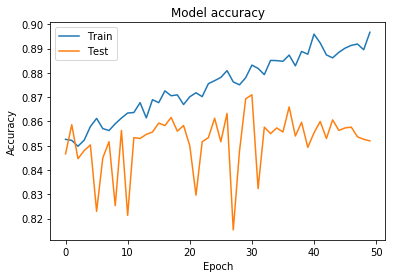

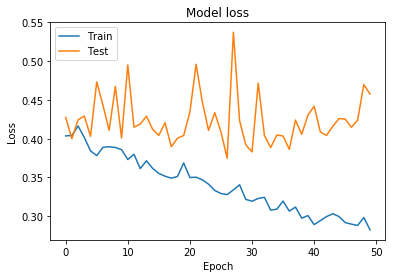

In [0]:
# Plot training & validation accuracy values
plt.plot(trained_model2.history['acc'])
plt.plot(trained_model2.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(trained_model2.history['loss'])
plt.plot(trained_model2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
all_hist = appendHist(all_hist, trained_model3.history)

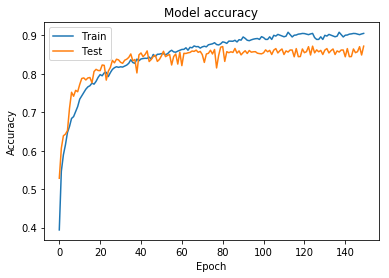

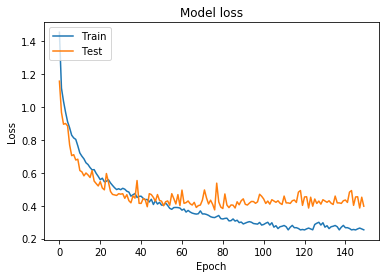

In [0]:
# Plot training & validation accuracy values
plt.plot(all_hist['acc'])
plt.plot(all_hist['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(all_hist['loss'])
plt.plot(all_hist['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [44]:
model.evaluate_generator(test_generator)

[0.5073292326227824, 0.8500299998410543]